In [1]:
import numpy as np
import pandas as pd
#禁用科学计数法
# np.set_printoptions(suppress=True,   precision=4,  threshold=2000,  linewidth=150)
# pd.set_option('display.float_format',lambda x : '%.2f' % x)

In [2]:
def polymodContactMatrix(ageGroupDefRange, socialContactOneyear, ageDistributionOneyear, totalPopulation):
    '''
    % Input parameters
    % 1. Contact matrix 1-year interval
    % 2. Population age distribution of that specific country
    % 3. Total population of that specific country

    % 1. Reformat contact matrix description array
    % start year - end year - interval in between
    '''
    # ageGroupDefRange = [-1, 19, 59, 84]
    # 将年龄层分段
    descriptionArray = np.zeros((len(ageGroupDefRange) - 1, 3))
    for ii in range(len(ageGroupDefRange) - 1):
        descriptionArray[ii, :] = [ii + 1, max(ageGroupDefRange[ii] + 1, 0), ageGroupDefRange[ii + 1] - max(ageGroupDefRange[ii] + 1, 0)]
    
    '''
    Shape : (3, 3)
    1  0 19
    2 20 39
    3 60 24
    '''
    descriptionArray = descriptionArray.astype(int)
    '''
    % 2. Output matrix
    '''
    # (3, 3)
    outputContactMatrix = np.zeros((max(descriptionArray[:, 0]), max(descriptionArray[:, 0])))
    for ii in range(max(descriptionArray[:, 0])):
        for jj in range(max(descriptionArray[:, 0])):
            sumContact = 0
            '''
            划分成3个年龄组
            0-20
            20-60
            60-85
            '''
            workingMatrix = socialContactOneyear.values[descriptionArray[ii, 1]:(descriptionArray[ii, 1] + descriptionArray[ii, 2] + 1),
                           descriptionArray[jj, 1]:(descriptionArray[jj, 1] + descriptionArray[jj, 2]) + 1]
            # (20, ), (40,) (25, )
            sumColumnMatrix = np.zeros(descriptionArray[jj, 2] + 1)
            # 计算这一小撮人的总和（行），所以sumColumnMatrix's shape ==> (20, ) (40, ) (25, )
            for kk in range(descriptionArray[jj, 2] + 1):
                sumColumnMatrix[kk] = np.sum(workingMatrix[:, kk])
            # 这一小撮人的比例总和，1~20岁，20～60岁，60～85岁
            sumAgeDistributionOneyear = np.sum(ageDistributionOneyear[descriptionArray[jj, 1]:(descriptionArray[jj, 1] + descriptionArray[jj, 2] + 1)])
            
            # 将 contactMatrix 和 年龄层比例相乘 （每个相乘），然后汇总，最后
            for mm in range(descriptionArray[jj, 2] + 1):
                sumContact += sumColumnMatrix[mm] * ageDistributionOneyear[descriptionArray[jj, 1] + mm]
                outputContactMatrix[ii, jj] = sumContact / sumAgeDistributionOneyear

    '''
    % 5. Adjusted contact matrix, symmetric
    '''
    AgeDistribution = np.zeros(max(descriptionArray[:, 0])) # (3, )
    for ii in range(max(descriptionArray[:, 0])): # 年龄层比例加和, 1~20, 20~60, 60~85
        AgeDistribution[ii] = np.sum(ageDistributionOneyear[descriptionArray[ii, 1]:(descriptionArray[ii, 1] + descriptionArray[ii, 2] + 1)])
    AgeDisPopulation = AgeDistribution * totalPopulation # 三个年龄层的人口数

    # outputContactMatrix (3, 3) 行竖* 对应的AgeDisPopulation(比例) / 2
    adOutputContactMatrix = np.zeros((max(descriptionArray[:, 0]), max(descriptionArray[:, 0]))) # (3, 3)
    for ii in range(max(descriptionArray[:, 0])):
        for jj in range(max(descriptionArray[:, 0])):
            adOutputContactMatrix[ii, jj] = 0.5 * (outputContactMatrix[ii, jj] / AgeDisPopulation[ii] + outputContactMatrix[jj, ii] / AgeDisPopulation[jj])
    return adOutputContactMatrix, AgeDistribution


In [3]:
from datetime import datetime

# 0. Date
dateZero = datetime.strptime('2022/10/31', '%Y/%m/%d')
dateChange = (datetime.strptime('2022/11/18', '%Y/%m/%d') - dateZero).days
dateEnd = (datetime.strptime('2022/12/22', '%Y/%m/%d') - dateZero).days

# 1. Contact pattern
# Define age groups
dataDir = './data/'
countryText = 'China_subnational_Beijing'
totalPopulation = 21893095
ageGroupDefRange = [-1, 19, 59, 84]

In [4]:
import pandas as pd
import numpy as np

# Age distribution
ageDistrTemp = pd.read_csv(dataDir + 'age_distributions/' + countryText + '_age_distribution_85.csv', header=None)
ageDistributionOneyear = ageDistrTemp[1].values / np.sum(ageDistrTemp[1].values) # proportion
totalPop = totalPopulation

<BarContainer object of 85 artists>

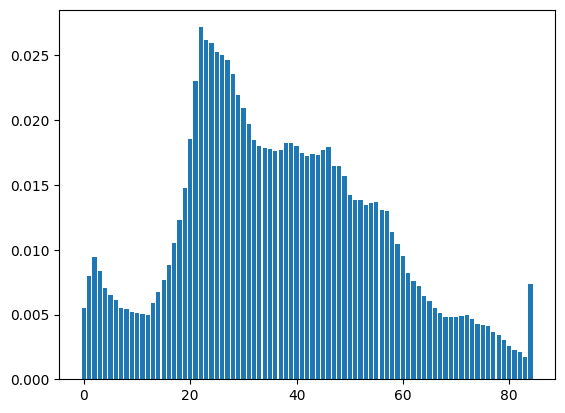

In [5]:
import matplotlib.pylab as plt
%matplotlib inline

plt.bar(range(len(ageDistributionOneyear)), ageDistributionOneyear)

In [6]:
# Contact matrix by setting
overallMatr = pd.read_csv(dataDir + 'contact_matrices/' + countryText + '_M_overall_contact_matrix_85.csv', header=None)
print(overallMatr.shape)
overallMatr,ageDistribution = polymodContactMatrix(ageGroupDefRange,overallMatr,ageDistributionOneyear,totalPop)

contactMatr = overallMatr
totalPopulation = totalPop*ageDistribution # 分层的人口
totalPopulationAgeBand = totalPopulation # 分层的人口

(85, 85)


In [7]:
totalPopulationAgeBand

array([ 3256881.48296989, 15940142.88058065,  2696070.63644947])

In [8]:
# % 2. Load Beijing MTR data
bjMTRdata = pd.read_excel('./data/2022_12_22_subway_beijing.xlsx')
# % Moving average
bjMTRdata.date = (bjMTRdata['date'] - dateZero).dt.days
bjMTRdata.total = bjMTRdata['total'].rolling(5, min_periods=3, center=True).mean() # mean(sum(frist five values))

In [9]:
# 计算 cutoffDate 的值
cutoffDate = pd.to_datetime('2022/11/30', format='%Y/%m/%d') - dateZero # 2022/10/31
cutoffDate = cutoffDate.days # 30

localCase = pd.read_excel("./data/2022_12_13_reported_case_beijing.xlsx")
# 计算日期列相对于 dateZero 的差值
localCase['date'] = (localCase['date'] - dateZero).dt.days
# 选取 date 小于等于 cutoffDate 的行，
# 即：2022/11/1 ~ 2022/11/30 的数据
localCase = localCase[localCase['date'] <= cutoffDate]
# 每日新增确诊人数
localCase['num_local_case'] = localCase['num_new_confirmed_case_local']
# localCase.rename(columns={'num_new_confirmed_case_local': 'num_local_case'}, inplace=True)

In [10]:
# 使用左连接合并两个表格
# total: 每天总的地铁流量
# num_local_case: 每日新增确诊人数
dataBeijing = pd.merge(bjMTRdata[['date', 'total']], localCase[['date', 'num_local_case']], on='date', how='left')

In [11]:
# % 4. Load Beijing prevalence data
# 微博投票数据
# 2022/12/10 ~ 2022/12/22
prevData = pd.read_excel("./data/2022_12_22_prevalence_beijing.xlsx")
prevData.date = (prevData['date'] - dateZero).dt.days

In [12]:
# % 5. Load serial interval data
genTimeData = pd.read_csv('./data/si_data_20200508.csv')
# 选取第 3 列和第 4 列
genTimeData = genTimeData.iloc[:, 2:4].values

In [13]:
# % Model parameters
scaleRt = [0.03,0.07]
genTime = 4.6
seedSize = 100
propReport = 0.1
propAscertain = 0.8

# % Fixed child
childSuscept = 1

# % Fixed parameters
tStart = 1
tEnd = dateEnd # 2022/12/22

# incubation period
meanIncubation = 3.5
stdIncubation = 3.9 / 5.2 * meanIncubation

In [14]:
shapeIncu = (stdIncubation * stdIncubation) / meanIncubation
scaleIncu = meanIncubation / shapeIncu
numDays = tEnd - tStart

Matlab中的gamcdf和python的cdf计算公式不一样，重写一个

\begin{equation}
p=F(x \mid a, b)=\frac{1}{b^a \Gamma(a)} \int_0^x t^{a-1} e^{\frac{-t}{b}} d t .
\end{equation}

In [15]:
from scipy.integrate import quad # 积分公式

def f(t, a, b):
    return t ** (a - 1) * np.exp(-t / b)

def gamma_cdf_m(x, a, b):
    result, error = quad(f, 0, x, args=(a, b))
    return result / (b ** a * np.math.gamma(a))

def gamma_cdf_m_array(x_array, a, b):
    results = []
    for x in x_array:
        results.append(gamma_cdf_m(x, a, b))
    return np.array(results)

In [16]:
from scipy.stats import gamma

# 潜伏期的概率密度函数
# 为什么要相减？ np.arange(2, numDays+2) - np.arange(1, numDays+1)
# 取前20的意义是？
pdfIncubation = gamma_cdf_m_array(np.arange(2, numDays+2), shapeIncu, scaleIncu) - gamma_cdf_m_array(np.arange(1, numDays+1), shapeIncu, scaleIncu)
pdfIncubation = pdfIncubation[:20]

In [17]:
# 潜伏期的累积分布函数
cdfIncubation = np.cumsum(pdfIncubation)
cdfIncubation[-1] = 1

In [18]:
totalPopulation = totalPopulationAgeBand
numEstate = 1
numIstate = 4
numRstate = 4
durExposed = 1
dt = 0.1

Infectious states
$$k = 4$$
$$\frac{dI_{a, 1}(t)}{dt} = -\gamma_I I_{a, 1}(t) + \gamma_E E_a(t)$$
$$\frac{dI_{a, 2}(t)}{dt} = -\gamma_I I_{a, 2}(t) + \gamma_I I_{a, 1}(t)$$
$$\frac{dI_{a, k}(t)}{dt} = -\gamma_I I_{a, k}(t) + \gamma_I I_{a, k-1}(t)$$

In matlab **sum** function:
- sum(A, 2): Create a matrix and compute the sum of the elements in each column. (ROW)
- sum(A, 1): vertical

In python:
- matrix.sum(axis=1): # of the elements in each column (ROW)
- matrix.sum(axis=0): vertical

python sketch map:
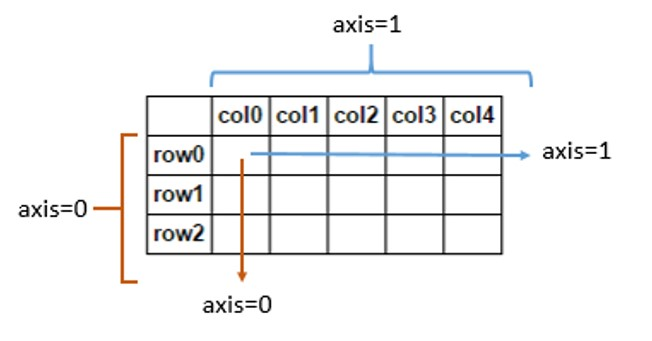

In [19]:
import math
from numpy import linalg as LA


# SEIR model

def SEIR_memory(scaleRt,contactMatrHome,childSuscept,genTime,seedSize,
                totalPopulation,durExposed,dataMTR,
                numEstate,numIstate,dt,tStart,tEnd,dateChange):
    
    '''
    dataMTR: dataMTR[total] / dataMTR[date==1].total, 除以第一天的地铁流量
    dt: 0.1
    '''
    
    maxTime = (tEnd-tStart)+1 # 52天
    # % SEIR model from Wu et al, PLOS Pathogens
    # 3 groups
    numAgeGroup = len(totalPopulation)

    # % Intermediate variables
    dSdt = np.zeros(numAgeGroup) # (3, )
    dEdt = np.zeros((numEstate,numAgeGroup)) # (4, 3)
    dIdt = np.zeros((numIstate,numAgeGroup)) # (1, 3)

    dymRt = np.array([None] * (int(maxTime/dt) - 1)) # shape = (519, )
    # % Record variables
    incidence = np.zeros((int(maxTime/dt),numAgeGroup)) # shape = (520, 3)
    # % Duration of sub-E and sub-I states
    subEduration = durExposed/numEstate # 1/1
    durInfectious = 2*(genTime-durExposed)*numIstate/(numIstate+1)
    subIduration = durInfectious/numIstate

    # % Contact matrix
    # contactMatr = np.empty((1,maxTime))
    contactMatr = [None] * maxTime
    iiMobility = np.zeros((maxTime,1))
    ngmBeta = np.zeros((maxTime,1))
    for iiMatr in range(maxTime):
        if iiMatr <= len(dataMTR):
            iiMobility[iiMatr,:] = np.tile(dataMTR[iiMatr], (1,1))
        else:
            iiMobility[iiMatr,:] = np.tile(np.mean(dataMTR[-7:]), (1,1))

    iiMobility = pd.DataFrame(iiMobility).rolling(5, min_periods=3, center=True).mean().values
    # contactMatrOct = np.empty((maxTime,1))
    contactMatrOct = [None] * maxTime

    for iiMatr in range(maxTime):
        iiMatr_index = iiMatr + 1
        if iiMatr_index <= dateChange-7:
            contactMatrOct[iiMatr] = (1-np.exp(-iiMobility[iiMatr, 0]))*scaleRt[0]*contactMatrHome
        else:
            if iiMatr_index > dateChange-7 and iiMatr_index <= dateChange+7:
                iiScale = scaleRt[0] + (scaleRt[1] - scaleRt[0]) / 14 * (iiMatr_index-dateChange+7)
                contactMatrOct[iiMatr] = (1-np.exp(-iiMobility[iiMatr,0]))*iiScale*contactMatrHome
            else:
                contactMatrOct[iiMatr] = (1-np.exp(-iiMobility[iiMatr,0]))*scaleRt[1]*contactMatrHome
        contactMatr[iiMatr] = contactMatrOct[iiMatr] * np.array([
            [childSuscept, 1, 1],
            [childSuscept, 1, 1],
            [childSuscept, 1, 1]
        ])
        # python可以直接提取出ngmEig，不用计算ngmDig
        # [~,ngmDig] = eig(contactMatr{iiMatr}.*repmat(totalPopulation',1,numAgeGroup)*genTime); 
        # ngmEig = ngmDig((1:numAgeGroup)+numAgeGroup*(0:(numAgeGroup-1)));

        ngmEig = LA.eig(contactMatr[iiMatr] * totalPopulation.reshape(numAgeGroup, 1) * genTime)[0]
        ngmBeta[iiMatr, 0] = max(ngmEig)
        # % contactMatr{iiMatr} = contactMatr{iiMatr}
        # % recRt(iiMatr,1) = ngmBeta(iiMatr,1)*max(ngmEig);

    # % Initial conditions
    # % 1. State S
    stateS = totalPopulation - seedSize/sum(totalPopulation)*totalPopulation
    # % 2. State E
    stateE = np.tile(seedSize/numEstate/sum(totalPopulation)*totalPopulation, (numEstate,1))
    # % 3. State I
    stateI = np.zeros((numIstate,numAgeGroup))

    for tt in range(int(maxTime/dt) - 1):
        tday = tt * dt
        # ceil: Round toward positive infinity, 正向无穷大四舍五入
        # 但是在python中，index从0开始，所以要反过来，所以要用floor
        contactMatrWork = contactMatr[math.floor(tday)] # length of contaqctMatr is 52
        for ii in range(numAgeGroup):
            dSdt[ii] = -stateS[ii] * ngmBeta[math.floor(tday), 0] * np.sum(contactMatrWork[ii,:] * stateI.sum(axis=0))

        # % Exposed states
        for ii in range(numEstate):
            if ii == 0:
                dEdt[ii, :] = -dSdt.reshape(3, 1).sum(axis=1) - stateE[0,:] / subEduration
            else:
                dEdt[ii, :] = stateE[ii-1,:] / subEduration - stateE[ii, :] / subEduration
        # % Infectious states
        '''
        $$k = 4$$
        $$\frac{dI_{a, 1}(t)}{dt} = -\gamma_I I_{a, 1}(t) + \gamma_E E_a(t)$$
        $$\frac{dI_{a, 2}(t)}{dt} = -\gamma_I I_{a, 2}(t) + \gamma_I I_{a, 1}(t)$$
        $$\frac{dI_{a, k}(t)}{dt} = -\gamma_I I_{a, k}(t) + \gamma_I I_{a, k-1}(t)$$
        '''
        for ii in range(numIstate):
            if ii == 0:
                # stateE[-1, :] : arrary (1, 3) to vector (3, )
                dIdt[ii, :] = stateE[-1, :] / subEduration - stateI[ii, :] / subIduration
            else:
                dIdt[ii, :] = stateI[ii-1, :] / subIduration - stateI[ii, :] / subIduration

        # % Update state variables
        stateS = stateS + dSdt*dt
        stateE = stateE + dEdt*dt
        stateI = stateI + dIdt*dt
        # % Update incidence record
        incidence[tt,:] = -np.sum(dSdt.reshape(3, 1),1)*dt
        # sum(A, 2) 行 (matlab) -> python axis=1
        # incidence[tt,:].reshape(1, -1) ==> (1, 3) ==> sum() ==> one element
        dymRt[tt] = (incidence[tt,:].reshape(1, -1).sum(axis=1) / stateI.sum() * genTime / dt)[0]

    # py: start, stop, step;
    # m: start, step, stop
    dymRtDaily = dymRt[np.arange(int(1/dt/2), len(dymRt), int(1 / dt))]

    dailyInc = np.zeros((maxTime))
    for tt in range(maxTime):
        dailyInc[tt] = incidence[[int(tt/dt+i) for i in  range(int(1/dt))],:].sum()

    out = np.column_stack((np.array(range(tStart, tEnd+1)), dailyInc, np.cumsum(dailyInc)))
    
    return out, dymRtDaily

gamma pdf in matlab:

- The gamma distribution is a two-parameter family of curves. The parameters *a* and *b* are shape and scale, respectively.  
- The gamma pdf is

  \begin{equation}
  y=f(x \mid a, b)=\frac{1}{b^a \Gamma(a)} x^{a-1} e^{\frac{-x}{b}}
  \end{equation}
    
- where $\Gamma(·)$ is the Gamma function.  
- The standard gamma distribution occurs when *b* = 1.  

Binomial probability density function

\begin{equation}
y=f(x \mid n, p)=\left(\begin{array}{l}
n \\
x\end{array}\right) p^x q^{(n-x)} I_{(0,1, \ldots, n)}(x)
\end{equation}


binopdf (m):

$$ y=f(x \mid n, p)=\left(\begin{array}{l}
n \\
x
\end{array}\right) p^x q^{(n-x)} I_{(0,1, \ldots, n)}(x) $$

where $q = 1 – p$. The resulting value $y$ is the probability of observing exactly $x$ successes in $n$ independent trials, where the probability of success in any given trial is $p$. The indicator function $I_{(0,1, \ldots, n)}(x)$ ensures that $x$ only adopts values of $0, 1, ..., n$.

In [20]:
def gamma_pdf_m(x, a, b):
    return (1 / (b ** a * np.math.gamma(a))) * np.power(x, a - 1) * np.exp(-x / b)
# method 2:
# $$y = \frac{b^a \times x^{(a-1)} \times e^{-bx}}{\gamma(a)}$$
# same fucntion
# def py_pdf(x, a, b):
#     y = ((b**a) * (x**(a-1)) * np.exp(-b*x)) / np.math.gamma(a)
#     return y
# py_pdf(5, 4, 1/1.15)

from scipy.stats import binom

# 自己写:
# from scipy.special import comb
# def binopdf(x, n, p):
#     q = 1 - p
#     y = comb(n, x) * p**x * q**(n-x)
#     y = np.where((x >= 0) & (x <= n), y, 0)
#     return y


def totalLogLikelihood(dataBeijing,genTimeData,prevData,
                       scaleRt,genTime,seedSize,propReport,propAscertain,
                       contactMatr,childSuscept,totalPopulation,durExposed,
                       numEstate,numIstate,dt,tStartArr,tEndArr,dateChange,pdfIncubation):
    '''
    dataBeijing: 11/1-11/30，地铁流量，感染人数
    genTimeData: SI的数据 (-1, 2)
    prevData: 微博投票数据（2022/12/10-12/22)，参与人数，感染，未感染人数
    scaleRt: Rt范围 [0.03,0.07]
    genTime: 4.6
    seedSize: 100
    propReport: 0.1
    propAscertain: 0.8,
    contactMatr: (3, 3), 通过polymodContactMatrix计算后的接触矩阵，原始接触矩阵与人口比例之间的计算得到（见ipad）
    childSuscept: 1,
    totalPopulation: 分层3个年龄层的具体人口数
    durExposed: 持续暴露 1
    numEstate: 暴露状态 1
    numIstate: 感染状态 infectious states 4
    dt: 0.1
    tStartArr: 1 （2022/11/01）开始时间
    tEndArr: 52 （2022/12/22）结束时间
    dateChange: 18 （2022/11/18）
    pdfIncubation: 潜伏期的概率密度函数
    '''
    if type(tStartArr) != np.ndarray:
        tStartArr = np.array([tStartArr])
        tEndArr = np.array([tEndArr])
    
    # % 1. Log likelihood of generation time distribution
    exactGenTimeLogL = np.sum(np.log(gamma_pdf_m(genTimeData[genTimeData[:, 0] == genTimeData[:, 1], 1], numIstate, genTime/numIstate)))
    g_cdf_1 = gamma_cdf_m_array(genTimeData[genTimeData[:, 0] != genTimeData[:, 1], 1], numIstate, genTime/numIstate)
    g_cdf_2 = gamma_cdf_m_array(genTimeData[genTimeData[:, 0] != genTimeData[:, 1], 0], numIstate, genTime/numIstate)
    intervalGenTimeLogL = np.sum(np.log(g_cdf_1 - g_cdf_2))

    for iiWave in range(len(tStartArr)):
        tStart = tStartArr[iiWave]
        tEnd = tEndArr[iiWave]
        dailyRec, _ = SEIR_memory(scaleRt, contactMatr,childSuscept,genTime,seedSize,totalPopulation,durExposed,
                                dataBeijing['total'].values / dataBeijing.total[dataBeijing.date==1].values,
                                numEstate,numIstate,dt,tStart,tEnd,dateChange)
        
        dailyInc = dailyRec[:,[0, 1]]
        dailyCumInc = dailyRec[:,[0,2]]

        # % convolution
        dailyOnset = np.zeros((len(dailyInc)+len(pdfIncubation)-1, len(dailyInc[0,:])-1))

        for iiDay in range(len(dailyInc[:, 0])):
            for iiAge in range(len(dailyInc[0, :]) - 1):
                # 0: 0+20: (iiDay, iiDay+20)
                dailyOnset[iiDay:(iiDay+len(pdfIncubation)), iiAge] = dailyOnset[iiDay:(iiDay+len(pdfIncubation)),iiAge] + dailyInc[iiDay,iiAge+1]*pdfIncubation

        # % Incidence: Poisson likelihood
        obsOnset = dailyOnset.sum(axis=1) # (71, 1) -> (71, ) ROW
        # dailyInc[0, 0] == 1，奇怪操作，直接 range(len(obsOnset))就可以了
        obsOnset_index = [int(dailyInc[0, 0]-1 + o) for o in range(len(obsOnset))]
        obsOnset = np.column_stack((obsOnset_index, obsOnset))
        obsOnset = obsOnset[tStart-1:tEnd, :]
        # shape 52 -> 30, ismember (m) -> np.in1d (py)
        obsOnset = obsOnset[np.in1d(obsOnset[:, 0]+1, dataBeijing['date'].values[~np.isnan(dataBeijing['num_local_case'].values)]), :]
        onsetData = np.column_stack((dataBeijing['num_local_case'].values[np.in1d(dataBeijing['date'].values, obsOnset[:,0] + 1)], obsOnset[:, 1]))
        onsetData = onsetData[np.arange(4, (dateChange - 7)), :]
        
        def LogL(k, n, p):
            y = binom.pmf(k, n, p)
            if y == 0:
                return -np.inf
            else:
                return np.log(y)
        
        onsetLogL = []
        for k, n in zip(onsetData[:, 0].astype(int), np.around(onsetData[:, 1]).astype(int)):
            onsetLogL.append(LogL(k, n, propReport))
        onsetLogL = np.sum(onsetLogL)
        # onsetLogL = np.sum(np.log(binom.pmf(k=onsetData[:, 0].astype(int), n=np.around(onsetData[:, 1]).astype(int), p=propReport)))

        # % Prevalence: Binomial likelihood
        pSens = propAscertain
        prevaData = np.column_stack((prevData['no_ever_positive'].values, prevData['no_participants'].values, pSens * np.array([dailyCumInc[d-1, 1] for d in prevData['date'].values]) / np.sum(totalPopulation)))
        
        prevalenceLogL = []
        for k, n, p in zip(prevData['no_ever_positive'].values, prevData['no_participants'].values, (pSens * np.array([dailyCumInc[d-1, 1] for d in prevData['date'].values]) / np.sum(totalPopulation))):
            prevalenceLogL.append(LogL(k, n, p))
        prevalenceLogL = np.array(prevalenceLogL)
        # prevalenceLogL = np.log(binom.pmf(k=prevData['no_ever_positive'].values, n=prevData['no_participants'].values, p=(pSens * np.array([dailyCumInc[d-1, 1] for d in prevData['date'].values]) / np.sum(totalPopulation))))
    
    onsetLogL = -1e9 if onsetLogL == -np.inf else onsetLogL
    prevalenceLogL = [-1e9 if pLogl == -np.inf else pLogl for pLogl in prevalenceLogL]

    # print(onsetLogL)
    # print(prevalenceLogL)
    
    totalLogL = exactGenTimeLogL + intervalGenTimeLogL + np.sum(np.sum(onsetLogL)) + np.sum(np.sum(prevalenceLogL))
    
    return totalLogL

In [21]:
totalLogL = totalLogLikelihood(dataBeijing,genTimeData,prevData,scaleRt,genTime,seedSize,propReport,
                                propAscertain,contactMatr,childSuscept,totalPopulation,durExposed,numEstate,
                                numIstate,dt,tStart,tEnd,dateChange,pdfIncubation)


In [ ]:
# test Likelihood function
x0 = list(scaleRt) # scaleRt (2, )
x0.extend([genTime,seedSize,propReport,propAscertain])
x0 = np.array(x0)
x0LowerBound = np.array([0.001,0.001,genTime,0,0,0])
x0UpperBound = np.array([1.100,1.100,genTime,3000,1,1])

In [ ]:
def negTotalLogLikelihood(x0,dataBeijing,genTimeData,prevData,contactMatr,childSuscept,totalPopulation,durExposed,
                            numEstate,numIstate,dt,tStart,tEnd,dateChange,pdfIncubation):

    scaleRt = x0[:2]
    genTime = x0[2]
    seedSize = x0[3]
    propReport = x0[4]
    propAscertain = x0[5]

    totalLogL = totalLogLikelihood(dataBeijing,genTimeData,prevData,scaleRt,genTime,seedSize,propReport,
                                    propAscertain,contactMatr,childSuscept,totalPopulation,durExposed,
                                    numEstate,numIstate,dt,tStart,tEnd,dateChange,pdfIncubation)

    out = -totalLogL
    return out

In [ ]:
# % Point estmates from fmincon
# 创建一个匿名函数，只用输入x，其他参数都是被固定的
redeffun = lambda x: negTotalLogLikelihood(x, dataBeijing,genTimeData,prevData,contactMatr,childSuscept,
                                            totalPopulation,durExposed,numEstate,numIstate,dt,tStart,tEnd,dateChange,pdfIncubation)

In [ ]:
# mcmc 优化好的参数
xfmin = [0.0237, 0.1065, 4.6000, 995.1762, 0.2687, 0.8165]
mcSteps = 20000
stepSize = [0.0002, 0.0003, 0, 37.9000, 0.0204, 0.0105]

In [ ]:
def calcMCMCTotalLogLikelihood(x0,dataBeijing,genTimeData,prevData,
                contactMatr,childSuscept,totalPopulation,durExposed,
                numEstate,numIstate,dt,tStart,tEnd,dateChange,pdfIncubation):

    scaleRt = x0[:2]
    genTime = x0[2]
    seedSize = x0[3]
    propReport = x0[4]
    propAscertain = x0[5]

    totalLogL = totalLogLikelihood(dataBeijing,genTimeData,prevData,
                scaleRt,genTime,seedSize,propReport,propAscertain,
                contactMatr,childSuscept,totalPopulation,durExposed,
                numEstate,numIstate,dt,tStart,tEnd,dateChange,pdfIncubation)

    out = totalLogL
    return out

In [ ]:
def mcmcProposal(parameters_c,parameterSteps,lowerRange,upperRange):

    parameters_new = -999*np.ones(len(parameters_c))
    while (parameters_new < lowerRange).any() or (parameters_new > upperRange).any():
        parameters_new = parameters_c + parameterSteps * (np.random.rand(len(parameters_c)) - 0.5) * 2
        parameters_new[parameters_new < lowerRange] = lowerRange[parameters_new < lowerRange] + (lowerRange[parameters_new < lowerRange] - parameters_new[parameters_new < lowerRange])
        parameters_new[parameters_new > upperRange] = upperRange[parameters_new>upperRange] + (parameters_new[parameters_new>upperRange] - upperRange[parameters_new>upperRange])

    return parameters_new

In [ ]:
def mcmcParallel(countryText,mcSteps,dataBeijing,genTimeData,prevData,
                contactMatr,childSuscept,totalPopulation,durExposed,
                numEstate,numIstate,dt,tStart,tEnd,dateChange,pdfIncubation,
                parameters,parameterSteps,lowerLimit,upperLimit):

    goodMC = False
    pAccept = 0.5*np.ones(len(parameters))
    numWhileLoop = 0
    numPars = len(parameters)

    while goodMC == False:
        numWhileLoop = numWhileLoop+1
        iPar = np.zeros((mcSteps,numPars))
        iiLogL = np.zeros((mcSteps,1))
        nAccept = np.zeros(numPars)

        for i, pA in enumerate(pAccept):
            if pA > 0.7:
                parameterSteps[i] = parameterSteps[i] * 1.2
            elif pA < 0.3:
                parameterSteps[i] = parameterSteps[i] / 1.25

        parameterSteps = np.column_stack((parameterSteps, upperLimit-lowerLimit)).min(axis=1)

        # % Current loglikelihood
        parameters_c = parameters.copy() # xflim
        logLikelihood = calcMCMCTotalLogLikelihood(parameters_c,dataBeijing,genTimeData,prevData,
                            contactMatr,childSuscept,totalPopulation,durExposed,
                            numEstate,numIstate,dt,tStart,tEnd,dateChange,pdfIncubation)

        for tt in range(mcSteps):
            tempNew = mcmcProposal(parameters_c,parameterSteps,lowerLimit,upperLimit)
            for ii in range(numPars):
                parameters_mc = parameters_c.copy()
                parameters_mc[ii] = tempNew[ii]
                logLikelihood_new = calcMCMCTotalLogLikelihood(parameters_mc,dataBeijing,
                                        genTimeData,prevData,contactMatr,childSuscept,totalPopulation,durExposed,
                                        numEstate,numIstate,dt,tStart,tEnd,dateChange,pdfIncubation)
                alpha = min(1, np.exp(logLikelihood_new-logLikelihood))
                uu = np.random.rand(1)[0]
                if uu <= alpha:
                    parameters_c = parameters_mc.copy()
                    logLikelihood = logLikelihood_new.copy()
                    nAccept[ii] = nAccept[ii] + 1
            
            iiLogL[tt, :] = logLikelihood
            iPar[tt, :] = parameters_c

            
            # % Check MCMC
            if tt % (mcSteps/100) == 0: # 求余数
                pAccept = nAccept / tt
                # write_matrix_new(parameterSteps,strcat('mcmc_result/',countryText,'_parameter_step.csv'),'w',',','dec');
                # write_matrix_new(iPar,strcat('mcmc_result/',countryText,'_mcmc_res.csv'),'w',',','dec');
                # write_matrix_new(iiLogL,strcat('mcmc_result/',countryText,'_log_likelihood.csv'),'w',',','dec');
                print('MCMC {}'.format(tt/mcSteps))
                print('Acceptance probability {}'.format(pAccept))
                if (pAccept > 0.7).any() or (pAccept < 0.3).any():
                    goodMC = False
                    if numWhileLoop < 20:
                        if tt/mcSteps >= 0.02:
                            break
                            # % goodMC = true;
                    else:
                        goodMC = True
                else:
                    goodMC = True
    return [iPar, iiLogL]

In [ ]:
xfmin

In [ ]:
out = mcmcParallel(countryText,mcSteps,dataBeijing,genTimeData,prevData,contactMatr,childSuscept,
                totalPopulation,durExposed,numEstate,numIstate,dt,tStart,tEnd,dateChange,pdfIncubation,
                xfmin,stepSize,x0LowerBound,x0UpperBound)

In [ ]:
# from scipy.optimize import fmin_slsqp

# #定义目标函数
# def objective_func(x):
#     return redeffun(x)

# #定义约束条件
# def constraint_func(x):
#     return x[0] + x[1] - 1

# #设置约束条件为等式约束
# eq_constraints = [{'type': 'eq', 'fun': constraint_func}]

# #初始点
# # x0 = [0, 0]

# #边界条件
# bounds = [(l, u) for l, u in zip(x0LowerBound, x0UpperBound)]

# #调用函数
# x_opt = fmin_slsqp(objective_func, xlim, bounds=bounds)

# print(x_opt)

In [ ]:
# from scipy.optimize import minimize

# def objective(x):
#     return redeffun(x)

# def callback(x):
#     print("y:{}".format(objective(x))) # 打印目标函数的值

# x0bounds = [(l, u) for l, u in zip(x0LowerBound, x0UpperBound)]
# options = {'maxiter': 1000, 'disp': True} # 设置最大迭代次数为100
# res = minimize(objective, xlim, bounds=x0bounds, method="SLSQP", options=options, callback=callback)

In [ ]:
# ! pip install scikit-opt

In [ ]:
# from scipy.optimize import differential_evolution

# def callback_func(x, convergence=0.5):
#     print(x, convergence)

# res = differential_evolution(objective_func, x0bounds, maxiter=10,seed=0, callback=callback_func)